![example](images/director_shot.jpeg)

## Movie Analysis

Aurthor: Tori Magin 

## Overview & Business Problem

Microsoft sees big companies creating original video content and they want to do get in on the action. They've decided to a create a new movie studio, but don’t know what type of movies they should make. 

Without a solid understanding of the current movie landscape, Microsoft will not be able to make confident decisions on content creation. Therefore, this analysis will use data from online data bases, IMDB and Box Office Mojo, to identify trends and highlight elements that typically make a movie successful. For example, does critical acclaim (high ratings) translate to higher revenue. 

*For this analysis 'success' is defined as box office revenue, i.e., 'gross'. 



## The Data & Method 

The data for this analysis came IMDB and Box Office Mojo as they have large databases, tracking many features of each movie. For example, IMDB can collate a large number of online reviews from a wide variety of sources to provide a representative average rating. 

The IMDB data (includes two data sets - "Basics" and "Ratings") describes the movie titles, release year, genres, running time, and ratings for movies from 2010 to present including future releases. 

The Box Office Mojo data details the domestic (US) and foreign gross each movie earned from 2010 to 2018. 

Only movie data from 2015 to 2022 was analysed to focus on the most recent and relevant trends. The average ratings, genres, and runtimes were  compared against the movies' total gross (combined domestic(US) and foreign gross) to identify elements of success. 


In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
basics = pd.read_csv("data/zippedData/imdb.title.basics.csv.gz")
gross = pd.read_csv("data/zippedData/bom.movie_gross.csv.gz")
ratings = pd.read_csv("data/zippedData/imdb.title.ratings.csv.gz")

## Data Preparation

The largest data set, IMDB Basics, was filtered to records from 2015 - 2022 to remove old and future data which could be unreliable or irrelevant. It was then merged with IMDB Ratings on 'tconst' the IMDB unique movie ID to make bnr (Basics 'n' Ratings).

In [3]:
basics['start_year_real']=pd.to_datetime(basics['start_year'], format='%Y')
recent_basics = basics.drop(basics[basics['start_year'] < 2015].index)

In [4]:
recent_basics = recent_basics.drop(recent_basics[recent_basics['start_year'] > 2022].index)

In [5]:
 recent_basics = recent_basics.set_index('tconst')
ratings = ratings.set_index('tconst')

In [6]:
bnr = pd.merge(recent_basics,ratings, on=['tconst'],how='left') 

In [7]:
#To merge with Box Office Mojo's Movie Gross， the 'primary title' column was renames 'title' to provide a common column to merge. 
bnr.rename(columns = {'primary_title':'title'}, inplace = True)

Gross was merged on to the new bnr data frame, however the new data frame (bnr_2) had a lot of missing gross values. 
Any records missing domestic_gross values were dropped. Because ~80% of the records had no domestic_gross value, they could not be reliably filled with placeholder values. 

In [8]:
bnr_2 = pd.merge(bnr,gross, on=['title'],how='left') 

In [9]:
bnr_2.dropna(subset=['domestic_gross'], inplace=True)

It was considered to also drop all foreign_gross null values, but this would result it too much data loss and the percentage of missing values was a more acceptable 43.7%, so it was decided to fill the null values with the foreign_gross median. The median was calculated using the original 'gross' dataset. 

In [10]:
bnr_2['foreign_gross'].isna().sum() /  (bnr_2['foreign_gross'].count()+bnr_2['foreign_gross'].isna().sum())

0.43741588156123823

In [11]:
gross.dropna(subset=['foreign_gross'], inplace=True)
gross['foreign_gross'] = gross['foreign_gross'].map(lambda x: x.replace(',',""))

In [12]:
gross.iloc[1300:1303]

,title,studio,domestic_gross,foreign_gross,year
1872,Star Wars: The Force Awakens,BV,936700000.0,1131.6,2015
1873,Jurassic World,Uni.,652300000.0,1019.4,2015
1874,Furious 7,Uni.,353000000.0,1163.0,2015


Atfer removing the commas, the values can be converted to floats. However, it's clear these numbers are not correctly formatted. 
Because there is only three, I manually replaced the values with the true foreign gross. 

In [13]:
gross['foreign_gross']= gross['foreign_gross'].replace([1131.6],1131561399)
gross['foreign_gross']= gross['foreign_gross'].replace([1019.4],1018130012)
gross['foreign_gross']= gross['foreign_gross'].replace([1163.0],1162040651)
gross.iloc[1300:1305]

,title,studio,domestic_gross,foreign_gross,year
1872,Star Wars: The Force Awakens,BV,936700000.0,1131.6,2015
1873,Jurassic World,Uni.,652300000.0,1019.4,2015
1874,Furious 7,Uni.,353000000.0,1163.0,2015
1875,Avengers: Age of Ultron,BV,459000000.0,946400000,2015
1876,Minions,Uni.,336000000.0,823400000,2015


In [14]:
gross['foreign_gross']= gross['foreign_gross'].astype('float')
f_gross_median = gross['foreign_gross'].median()
bnr_2['foreign_gross'] = bnr_2['foreign_gross'].fillna(f_gross_median)

The bnr_2 data set also had ',' values, these I replaced by correcting the decimal point position. 

In [15]:
bnr_2['foreign_gross']= bnr_2['foreign_gross'].replace(['1,131.6'],1131561399)
bnr_2['foreign_gross']= bnr_2['foreign_gross'].replace(['1,019.4'],1018130012)
bnr_2['foreign_gross']= bnr_2['foreign_gross'].replace(['1,163.0'],1162040651)
bnr_2['foreign_gross']= bnr_2['foreign_gross'].replace(['1,369.5'],1369500000)
bnr_2['foreign_gross']= bnr_2['foreign_gross'].replace(['1,010.0'],1010000000)

In [16]:
bnr_2['foreign_gross'] = bnr_2['foreign_gross'].astype('float')
bnr_2['total_gross'] = bnr_2['domestic_gross'] + bnr_2['foreign_gross']

#26 records had no genre, so it is easiest to remove this small number of records with missing info. 

In [17]:
bnr_2= bnr_2.dropna(subset=['genres'])

In [18]:
bnr_2['genreslist'] = bnr_2['genres'].tolist()

In [19]:
print(bnr_2['genres'].map(lambda x: x.split(',')))

18             [Action, Crime, Drama]
29        [Action, Adventure, Sci-Fi]
30                     [Crime, Drama]
32        [Biography, Drama, History]
43       [Action, Adventure, Fantasy]
                     ...             
76661                         [Drama]
76726                         [Drama]
76871                 [Action, Drama]
76901                         [Crime]
77239                   [Documentary]
Name: genres, Length: 1460, dtype: object


In [20]:
bnr_2.sort_values('start_year')

,title,original_title,start_year,runtime_minutes,genres,start_year_real,averagerating,numvotes,studio,domestic_gross,foreign_gross,year,total_gross,genreslist
10988,Experimenter,Experimenter,2015,98.0,"Biography,Drama,History",2015-01-01,6.6,16099.0,Magn.,156000.0,18700000.0,2015.0,18856000.0,"Biography,Drama,History"
8974,Fan,Anemistiras,2015,90.0,Drama,2015-01-01,5.8,22.0,Yash,2300000.0,25900000.0,2016.0,28200000.0,Drama
8848,Pan,Pan,2015,111.0,"Adventure,Comedy,Family",2015-01-01,5.8,55867.0,WB,35100000.0,93300000.0,2015.0,128400000.0,"Adventure,Comedy,Family"
8781,Regression,Regression,2015,106.0,"Crime,Horror,Mystery",2015-01-01,5.7,33335.0,W/Dim.,55000.0,17600000.0,2016.0,17655000.0,"Crime,Horror,Mystery"
19055,Eva,Eva,2015,82.0,Drama,2015-01-01,NaN,NaN,Wein.,16700.0,18700000.0,2015.0,18716700.0,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69041,The Last Stand,The Last Stand,2019,93.0,Drama,2019-01-01,NaN,NaN,LGF,12100000.0,36300000.0,2013.0,48400000.0,Drama
62039,Remember Me,Remember Me,2019,NaN,Thriller,2019-01-01,NaN,NaN,Sum.,19100000.0,37000000.0,2010.0,56100000.0,Thriller
77239,Unstoppable,Unstoppable,2019,84.0,Documentary,2019-01-01,8.1,8.0,Fox,81600000.0,86200000.0,2010.0,167800000.0,Documentary
3927,Eden,Eden,2020,NaN,Drama,2020-01-01,NaN,NaN,BG,65500.0,18700000.0,2015.0,18765500.0,Drama


## Data Modeling

The average ratings, genres, and runtimes were compared against the movies' total gross (combined domestic (US) and foreign gross) to identify elements of success. 

The data was separated into Top 100 Movies (highest total gross) and Bottom 100 Movies (lowest total gross) to provide two comparative sample sets. 

### 1. Analysis by Ratings

Ratings of the top and bottom 100 movies (by total gross) were examined. 

In [21]:
by_gross = bnr_2.sort_values('total_gross', ascending=False)
top_100 = by_gross['total_gross'][0:100]
top_100 = list(top_100)

len(top_100)

100

In [22]:
best_100 = by_gross['averagerating'][0:100]
best_100 = list(best_100)

len(best_100)

100

In [23]:
bottom_gross = bnr_2.sort_values('total_gross')
bottom_100 = bottom_gross['total_gross'][0:100]
bottom_100 = list(bottom_100)

In [24]:
worst_100 = bottom_gross['averagerating'][0:100]
worst_100 = list(worst_100)

len(worst_100)

100

In [25]:
tops = pd.DataFrame()
tops['Gross'] = top_100
tops['AvgRatings'] = best_100
tops = tops.dropna()

TopRatingsCor = tops.corr(method='pearson')
TopRatingsCor

,Gross,AvgRatings
Gross,1.000000,0.329525
AvgRatings,0.329525,1.000000


In [26]:
CorrelationDF = pd.DataFrame()
CorrelationDF['gross'] = bnr_2['total_gross']
CorrelationDF['Avg_Rating'] = bnr_2['averagerating']
CorrelationDF['runtime'] = bnr_2['runtime_minutes']

CorrelationDF
correlation = CorrelationDF.corr(method='pearson')
correlation

,gross,Avg_Rating,runtime
gross,1.000000,0.135255,0.137843
Avg_Rating,0.135255,1.000000,0.198598
runtime,0.137843,0.198598,1.000000


 AVG Rating Vs Gross Scatter Plot 

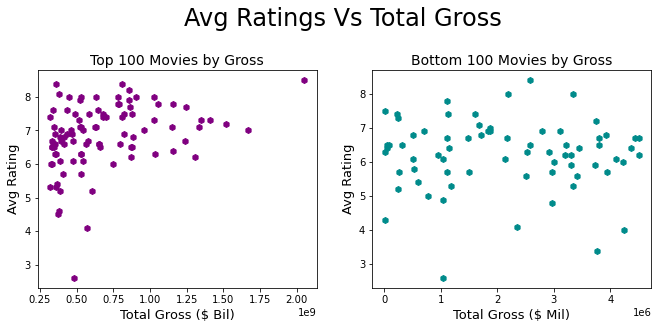

In [27]:
fig, (ax1, ax2) = plt.subplots(figsize=(11,4), ncols=2)

ax1.scatter(x=top_100, y=best_100, color='purple', marker='h')
ax1.set_xlabel('Total Gross ($ Bil)', fontsize=13)
ax1.set_ylabel('Avg Rating',  fontsize=13)
ax1.set_title('Top 100 Movies by Gross', fontsize=14)


ax2.scatter(x=bottom_100, y=worst_100,color='darkcyan', marker='h')
ax2.set_xlabel('Total Gross ($ Mil)', fontsize=13)
ax2.set_ylabel('Avg Rating',  fontsize=13)
ax2.set_title('Bottom 100 Movies by Gross', fontsize=14)

fig.suptitle("Avg Ratings Vs Total Gross", fontsize=24, x=0.51, y=1.1)

plt.savefig('./images/RatingsGrossScatter.png', bbox_inches = "tight")


### 2. Analysis by Runtime 


In [28]:
top_by_runtime = bnr_2.sort_values('total_gross', ascending=False)
Time_top_100 = top_by_runtime['runtime_minutes'][0:100]
Time_top_100 = list(Time_top_100)

Top_Avg_Runtime = (str(sum(Time_top_100) / 100) + " mins")

Top_Avg_Runtime

'115.79 mins'

In [29]:
TopRuntime = pd.DataFrame()
TopRuntime['Gross'] = top_100
TopRuntime['Runtime'] = Time_top_100 

TopRuntime = TopRuntime.dropna()


In [30]:
bottom_by_runtime = bnr_2.sort_values('total_gross')
Time_bottom_100 = bottom_by_runtime['runtime_minutes'][0:100]
Time_bottom_100 = list(Time_bottom_100)


In [31]:
BottomsRuntime = pd.DataFrame()
BottomsRuntime['Gross'] = bottom_100
BottomsRuntime['Runtime'] = Time_bottom_100 

BottomsRuntime = BottomsRuntime.dropna()

Avg_Bottom_Runtime = BottomsRuntime['Runtime'].mean()
Avg_Bottom_Runtime

97.62790697674419

 Runtime Vs Gross Scatter Plot 

Text(0.51, 1.1, 'Runtime Vs Gross')

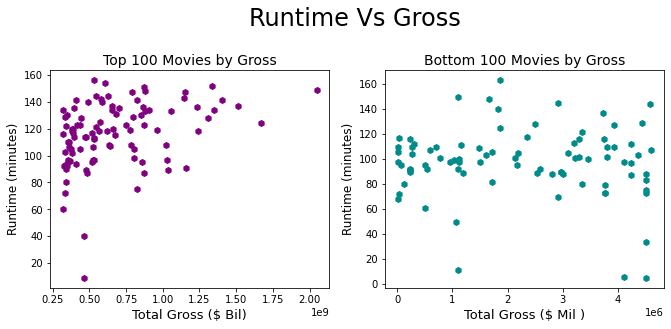

In [32]:
fig, (ax3, ax4) = plt.subplots(figsize=(11,4), ncols=2)

ax3.scatter(x=top_100, y=Time_top_100, color='purple', marker='h')
ax3.set_title('Top 100 Movies by Gross', fontsize = 14)
ax3.set_xlabel('Total Gross ($ Bil)', fontsize = 13)
ax3.set_ylabel('Runtime (minutes)', fontsize = 12)


ax4.scatter(x=bottom_100, y=Time_bottom_100,color='darkcyan', marker='h')
ax4.set_title('Bottom 100 Movies by Gross', fontsize = 14)
ax4.set_xlabel('Total Gross ($ Mil )', fontsize = 13)
ax4.set_ylabel('Runtime (minutes)', fontsize = 12)

plt.savefig('./images/RuntimeGrossScatter.png', bbox_inches = "tight")

fig.suptitle("Runtime Vs Gross", fontsize=24, x=0.51, y=1.1)


### 3. Analysis by Genre 


In [33]:
bnr_by_gross = bnr_2.sort_values('total_gross', ascending=False)
bnr_top100_by_gross = bnr_by_gross[0:100]

In [34]:
Top_genres = ""
for x in bnr_top100_by_gross['genreslist']:
    Top_genres += str(x) + ","
Top_genres = Top_genres.split(',')

len(Top_genres)

287

In [35]:
from collections import Counter
top_counts_average = Counter(Top_genres).most_common()
print(top_counts_average)
type(top_counts_average)

[('Adventure', 69), ('Action', 58), ('Comedy', 35), ('Animation', 24), ('Sci-Fi', 20), ('Drama', 18), ('Fantasy', 15), ('Thriller', 13), ('Horror', 6), ('Documentary', 5), ('Family', 4), ('Romance', 4), ('Biography', 3), ('Mystery', 3), ('Crime', 2), ('Music', 2), ('History', 2), ('Musical', 2), ('Sport', 1), ('', 1)]


list

In [36]:
top_names = []
for x in top_counts_average:
    top_names.append(x[0])

In [37]:
top_values = []
for x in top_counts_average:
    top_values.append(x[1])

In [38]:
bnr_by_gross_bottom = bnr_2.sort_values('total_gross')
bnr_bottom100_by_gross = bnr_by_gross_bottom[0:100]

len(bnr_bottom100_by_gross)

100

In [39]:
bottom_genres = ""
for x in bnr_bottom100_by_gross['genreslist']:
    bottom_genres += str(x) + ","
bottom_genres = bottom_genres.split(',')

len(bottom_genres)

200

In [40]:
from collections import Counter
bottom_counts_average = Counter(bottom_genres).most_common()
bottom_counts_average = bottom_counts_average[0:20]
len(bottom_counts_average)

20

In [41]:
bottom_names = []
for x in bottom_counts_average:
    bottom_names.append(x[0])

bottom_names = bottom_names[0:20]

In [42]:
bottom_values = []
for x in bottom_counts_average:
    bottom_values.append(x[1])

bottom_values = bottom_values[0:20]
print(bottom_names)
print(bottom_values)

['Drama', 'Documentary', 'Comedy', 'Thriller', 'Biography', 'Romance', 'Horror', 'Mystery', 'Music', 'Action', 'War', 'Family', 'Adventure', 'History', 'Crime', 'Fantasy', 'Animation', 'Sci-Fi', 'Sport', 'Western']
[57, 22, 21, 14, 14, 12, 8, 8, 7, 6, 5, 5, 5, 4, 3, 3, 2, 1, 1, 1]


Genre & Gross - Bar Chart

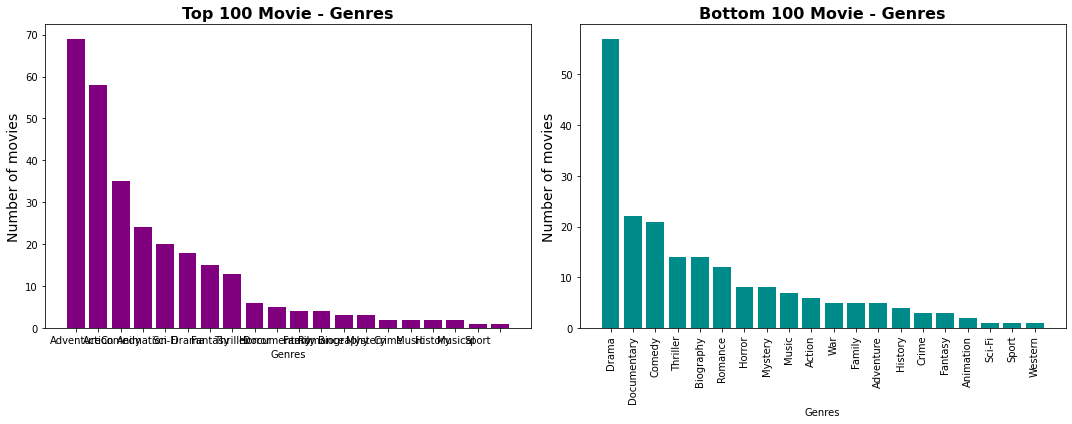

Text(0.5, 0.98, 'Common Genres for the Top & Bottom Movie Lists')

In [43]:
fig, (gt,gb) = plt.subplots(figsize=(15,6), ncols=2)

gt.bar(range(len(top_counts_average)), top_values, color=('purple'), tick_label=top_names)
plt.xticks(rotation = 90)
gt.set_ylabel('Number of movies', fontsize=14)
gt.set_xlabel('Genres')
gt.set_title('Top 100 Movie - Genres', fontweight="bold", fontsize =16)


gb.bar(range(len(bottom_counts_average)), bottom_values,color=('darkcyan'), tick_label=bottom_names)
plt.xticks(rotation=90)
gb.set_ylabel('Number of movies', fontsize=14)
gb.set_xlabel('Genres')
gb.set_title('Bottom 100 Movie - Genres', fontweight="bold",  fontsize =16)
fig.tight_layout()
plt.savefig('./images/Genres_Top_n_Bottom.png', bbox_inches = "tight")
plt.show();

fig.suptitle('Common Genres for the Top & Bottom Movie Lists', fontsize = '24')

Identifying Top Studios

In [44]:
Top_studios = ""
for x in bnr_top100_by_gross['studio']:
    Top_studios += str(x) + ","
Top_studios = Top_studios.split(',')

len(Top_studios)

101

In [45]:
from collections import Counter
topS_counts_average = Counter(Top_studios).most_common()
print(topS_counts_average)
type(topS_counts_average)

[('BV', 24), ('Uni.', 20), ('Fox', 15), ('WB', 14), ('Par.', 8), ('Sony', 7), ('WB (NL)', 4), ('LGF', 2), ('LG/S', 2), ('HC', 1), ('WGUSA', 1), ('FR', 1), ('FUN', 1), ('', 1)]


list

In [46]:
topS_names = []
for x in topS_counts_average:
    topS_names.append(x[0])
len(topS_names)

14

In [47]:
topS_values = []
for x in topS_counts_average:
    topS_values.append(x[1])
len(topS_values)

14

In [48]:
Bottom_studios = ""
for x in bnr_bottom100_by_gross['studio']:
    Bottom_studios += str(x) + ","
Bottom_studios = Bottom_studios.split(',')

len(Bottom_studios)

101

In [49]:
from collections import Counter
bottomS_counts_average = Counter(Bottom_studios).most_common()
type(bottomS_counts_average)

list

In [50]:
bottomS_names = []
for x in bottomS_counts_average:
    bottomS_names.append(x[0])
len(bottomS_names)

44

In [51]:
bottomS_values = []
for x in bottomS_counts_average:
    bottomS_values.append(x[1])
len(bottomS_values)

44

In [52]:
Top_Studios = pd.DataFrame()
Top_Studios['StudioName'] = topS_names
Top_Studios['#_of_Top100_Movies'] = topS_values

Top_Studios

,StudioName,#_of_Top100_Movies
0,BV,24
1,Uni.,20
2,Fox,15
3,WB,14
4,Par.,8
5,Sony,7
6,WB (NL),4
7,LGF,2
8,LG/S,2
9,HC,1


In [53]:
Bottom_Studios = pd.DataFrame()
Bottom_Studios['StudioName'] = bottomS_names
Bottom_Studios['#_of_Bottom100_Movies'] = bottomS_values


In [54]:
bnr_2.sort_values('start_year', ascending=False)

,title,original_title,start_year,runtime_minutes,genres,start_year_real,averagerating,numvotes,studio,domestic_gross,foreign_gross,year,total_gross,genreslist
3927,Eden,Eden,2020,NaN,Drama,2020-01-01,NaN,NaN,BG,65500.0,18700000.0,2015.0,18765500.0,Drama
72288,Cherry,Cherry,2020,NaN,Drama,2020-01-01,NaN,NaN,Abr.,11400.0,18700000.0,2010.0,18711400.0,Drama
77239,Unstoppable,Unstoppable,2019,84.0,Documentary,2019-01-01,8.1,8.0,Fox,81600000.0,86200000.0,2010.0,167800000.0,Documentary
3195,Wanderlust,Wanderlust,2019,NaN,Fantasy,2019-01-01,NaN,NaN,Uni.,17500000.0,4200000.0,2012.0,21700000.0,Fantasy
4889,The Negotiation,The Negotiation,2019,80.0,"Horror,Thriller",2019-01-01,NaN,NaN,CJ,111000.0,18700000.0,2018.0,18811000.0,"Horror,Thriller"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11631,Tangerine,Tangerine,2015,88.0,"Comedy,Crime,Drama",2015-01-01,7.1,23133.0,Magn.,702000.0,18700000.0,2015.0,19402000.0,"Comedy,Crime,Drama"
11683,A War,Krigen,2015,115.0,"Crime,Drama,War",2015-01-01,7.1,8599.0,Magn.,123000.0,18700000.0,2016.0,18823000.0,"Crime,Drama,War"
11706,War Room,War Room,2015,120.0,Drama,2015-01-01,6.5,11716.0,TriS,67800000.0,18700000.0,2015.0,86500000.0,Drama
11736,Shamitabh,Shamitabh,2015,155.0,Drama,2015-01-01,6.8,6444.0,Eros,325000.0,18700000.0,2015.0,19025000.0,Drama


## Evaluation
Evaluate how well your work solves the stated business problem.

Overall, the above data modelling does provide some useful insights, such as what genre of films to focus on and avoid. However, there's still many unknow factors for further analysis. For example, the movie production  costs are unknown, so we cannot examine net profit or loss. 

With more time, I would also run the same analysis over larger samples, for exmaple Top and Bottom 300 (which is approx. 20% of BNR_2). This may provide better generalisation of results. 

## Recommendations

1. Microsoft should not try to make content decisions based on potential movie ratings as:
  - The impact of ratings on gross is rather minor, and; 
  - A studio has limited direct control over future reviews.  
2. The runtime influence is also minor, but it is worth noting the significant difference in average runtime between Top and Bottom 100 Movies. This indicates audiences prefer longer, epic-like movies and is an area Microsoft should research for further insights. 

3. Microsoft should focus on action and adventure movies and avoid dramas and documentaries. The clearest distinction between the Top and Bottom 100 is the composition of genre, so this area should be considered most seriously.

4. Microsoft could consider the list of studios that produced the Top 100 and research further how these studios operate to gain insights on how successful movies are chosen and produced. 


## Conclusion
This analysis demonstrated the major factor influencing a movie’s success is the genre. Audiences have a strong preference for action and adventure movies and, to a lesser extent, comedy and animation. 
This analysis only looked at movie gross. Further research should examine movies by net profit and less to gain a better understanding profitability. 
Other factors, ratings and runtime, were not strongly correlated with the total movie gross. 

## Next Steps
 1. Conduct further research into movie production costs to understand the relationship between ratings, runtime, and genre and net profit or loss. 
 
 2. Explore other related factors to find stronger relationships. For example, the movie rating appeared to have little impact on movie gross, but number of reviews/ratings (i.e., level of media exposure) may be more impactful and worth examining. 